# OK Google, google the NASDAQ

## Part II - What happened in 2020? 

In the previous part, we knew that Google Trends data could improve predictions of NASDAQ index in spite of its random-walk habit. But more detailed discovers are still waiting. For example, in 2020, a special but weird year, which trends affects the NASDAQ most? Does COVID-19 appeal to the finance people?

So in this part, we collect several Google Trends in 2020 that are not related to NASDAQ directly, tring to explore the their underlying relation with the index.

 ### Data preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
### Data directory configs
DATA_DIR = './data/'
PLOT_DIR = './plots_data/'

In [3]:
# Load the NASDAQ index from 2020-1-1 to 2020-12-1
df_ns = pd.read_csv(DATA_DIR + 'Composite_2020.csv')
df_ns['Date'] = pd.to_datetime(df_ns['Date'])
df_ns.set_index('Date', inplace=True)

# There is no data available in the weekends, so we pad the blank row with linear interpolation method.
df_ns = df_ns.reindex(pd.date_range(start=pd.Timestamp('2020-1-1'), end=pd.Timestamp('2020-12-1'), freq='1D'))
df_ns.iloc[0] = df_ns.iloc[1]
df_ns.interpolate(method='linear', inplace=True)    
df_ns.head()

,Open,High,Low,Close,Adj Close,Volume
2020-01-01,9039.459961,9093.429688,9010.889648,9092.190430,9092.190430,2.848370e+09
2020-01-02,9039.459961,9093.429688,9010.889648,9092.190430,9092.190430,2.848370e+09
2020-01-03,8976.429688,9065.759766,8976.429688,9020.769531,9020.769531,2.567400e+09
2020-01-04,8965.453125,9067.976563,8965.453125,9037.669596,9037.669596,2.640973e+09
2020-01-05,8954.476563,9070.193359,8954.476563,9054.569662,9054.569662,2.714547e+09


In [4]:
# Load the Google Trends from 2020-1-1 to 2020-12-1. 
# Every trend has a worldwide indicator and a US indicator.
df_gt = pd.read_csv(DATA_DIR + 'Google_trends_2020.csv')
df_gt['date'] = pd.to_datetime(df_gt['date'])
df_gt.set_index('date', inplace=True)
df_gt.drop(['Unnamed: 0'], axis=1, inplace=True)
df_gt = df_gt[pd.Timestamp('2020-1-1'):pd.Timestamp('2020-12-1')]
df_gt.tail()

,vaccine_world,vaccine_US,unemployment_world,unemployment_US,trump_world,trump_US,lockdown_world,lockdown_US,loan_world,loan_US,italy_world,italy_US,election_world,election_US,covid_world,covid_US,china_world,china_US
date,,,,,,,,,,,,,,,,,,
2020-11-27,36.0,42.0,17.36,14.422222,8.0,16.0,12.923077,2.516129,60.2250,33.354839,13.575758,12.579710,0.5,0.5,43.0,45.617647,27.0,24.5
2020-11-28,39.0,47.0,14.26,12.455556,7.0,14.0,12.000000,4.645161,55.6625,33.354839,15.515152,14.405797,0.5,1.0,44.0,48.529412,27.6,26.0
2020-11-29,41.0,49.0,26.04,27.533333,7.0,13.0,11.076923,4.064516,52.9250,31.225806,15.515152,14.000000,0.5,0.5,43.0,49.500000,27.6,25.5
2020-11-30,48.0,61.0,31.62,30.155556,6.0,12.0,14.769231,4.064516,70.2625,42.580645,14.303030,12.782609,0.5,0.5,47.0,55.323529,28.8,28.0
2020-12-01,50.0,68.0,27.90,24.911111,6.0,12.0,13.846154,3.870968,72.0875,46.838710,13.818182,12.782609,0.5,0.5,47.0,55.323529,29.4,31.5


### Build the models

As the statistic of Google Trends is later than the close of NASDAQ every day, we still need to extract the data from the previous day as features.

In [5]:
data_2020 = df_gt.copy()
data_2020['close'] = df_ns['Close']
data_2020.fillna(0, inplace=True)

data_2020['close.l1'] = data_2020['close'].shift(1)
for feature in df_gt.columns:
    data_2020[feature] = data_2020[feature].shift(1)

data_2020 = data_2020.dropna()
data_2020.head()

,vaccine_world,vaccine_US,unemployment_world,unemployment_US,trump_world,trump_US,lockdown_world,lockdown_US,loan_world,loan_US,italy_world,italy_US,election_world,election_US,covid_world,covid_US,china_world,china_US,close,close.l1
date,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.000000,0.0,6.0,2.0,3.913043,6.835443,0.5,0.5,52.0,26.0,15.0,17.0,0.205882,0.181818,0.477778,0.5,27.0,29.0,9092.190430,9092.190430
2020-01-03,0.000000,0.0,10.0,4.0,3.521739,6.075949,0.5,0.5,74.0,45.0,15.0,16.0,0.264706,0.363636,0.477778,0.5,26.0,25.0,9020.769531,9092.190430
2020-01-04,0.384615,0.0,9.0,4.0,12.521739,16.708861,0.5,0.5,72.0,47.0,14.0,15.0,0.411765,0.363636,0.477778,0.5,27.0,28.0,9037.669596,9020.769531
2020-01-05,0.000000,0.0,6.0,2.0,10.369565,15.189873,0.5,0.5,63.0,37.0,15.0,17.0,0.294118,0.318182,0.477778,0.5,27.0,28.0,9054.569662,9037.669596
2020-01-06,0.000000,0.0,8.0,5.0,10.369565,14.430380,0.5,0.5,61.0,33.0,16.0,18.0,0.411765,0.363636,0.477778,0.5,27.0,27.0,9071.469727,9054.569662


In [6]:
label = 'close'
base_features = ['close.l1']

In [7]:
# Baseline model. Only use closing prices from the previous day as feature.
base_X = data_2020[base_features]
base_X = sm.add_constant(base_X)
base_y = data_2020[label]
base_model = sm.OLS(base_y, base_X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 2.539e+04
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          2.10e-316
Time:                        07:42:29   Log-Likelihood:                -2155.8
No. Observations:                 335   AIC:                             4316.
Df Residuals:                     333   BIC:                             4323.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.0091     62.961      0.524      0.6

In [8]:
# Use all Google Trends categories as features to see which feature has the most obvious impact.
total_features = df_gt.columns.to_list()
total_features.append('close.l1')

X = data_2020[total_features]
X = sm.add_constant(X)
y = data_2020[label]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1417.
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          4.25e-292
Time:                        07:42:29   Log-Likelihood:                -2136.9
No. Observations:                 335   AIC:                             4314.
Df Residuals:                     315   BIC:                             4390.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                578.3019    219

We just test a "hodgepodge" model using all the Google Trends data along with NASDAQ.l1. Although $R^2$ improves slightly, we know this model can be extremely bad at prediction. Larger coefficient probably just means it has some outliers that may influence the NASDAQ a lot. Just out of out of curiosity, we can't wait to see which trends data has such magic. 

In [9]:
df_params = pd.DataFrame(model.params[1:], columns=['coef'])
df_params['ratio'] = abs(df_params['coef'])/abs(df_params['coef']).sum() * 100
df_params.sort_values(by='ratio', inplace=True)

Text(0.5, 0, 'Coefficient(abs) in the linear model')

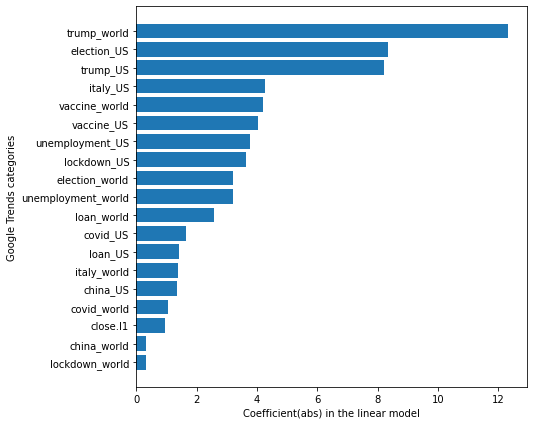

In [10]:
plt.figure(figsize=(7, 7))
plt.barh(y=df_params.index, width=abs(df_params['coef']))
plt.ylabel('Google Trends categories')
plt.xlabel('Coefficient(abs) in the linear model')

In [11]:
# df_params.to_csv(PLOT_DIR + 'all_trends_params.csv')

It's election, a event that only lasted for several weeks but left an indelible impact on the NASDAQ index. 

OK, let's go back to the main topic in out-of-sample forecasting to explore which the best predictor is. 

### Out-of-sample forecast

In [12]:
# We choose 2020-2-9 as the start date of the rolling window for out-of-sample forecase.
start_date = pd.Timestamp('2020-2-9')
start_index = data_2020.index.tolist().index(start_date)

In [13]:
base = [-1.0] * start_index
out_base_model = LinearRegression()

# As the rolling window become broader, more data can be used for trainig. 
for i in range(start_index, len(data_2020)):
    # Base model traing and predicting.
    out_base_model.fit(data_2020[:i][base_features], data_2020[:i][label])
    base_pred = out_base_model.predict([data_2020.iloc[i][base_features]])
    base.append(base_pred[0])
data_2020['base'] = base

In [14]:
# Trends model traing and predicting. 
# Features: closing prices from the previous day along with an additional Google Trends category.
for feature in data_2020.columns[0:len(df_gt.columns)]:
    trends = [-1.0] * start_index
    trends_features = ['close.l1', feature]
    out_trends_model = LinearRegression()
    for i in range(start_index, len(data_2020)):
        # Trends model training and predicting.
        out_trends_model.fit(data_2020[:i][trends_features], data_2020[:i][label])
        trends_pred = out_trends_model.predict([data_2020.iloc[i][trends_features]])
        trends.append(trends_pred[0])
    data_2020[f'{feature}_pred'] = trends

In [15]:
result = data_2020[start_date:]

improvements = {}
base_mae = sum(abs(result['base'] - result[label]))/len(result[label])
for feature in data_2020.columns[0:len(df_gt.columns)]:
    mae = sum(abs(result[f'{feature}_pred'] - result[label]))/len(result[label])
    improvements[feature] = (base_mae - mae) / base_mae
improvements = pd.Series(improvements)
improvements = improvements.sort_values()

Text(0.5, 1.0, 'Performance of trends models')

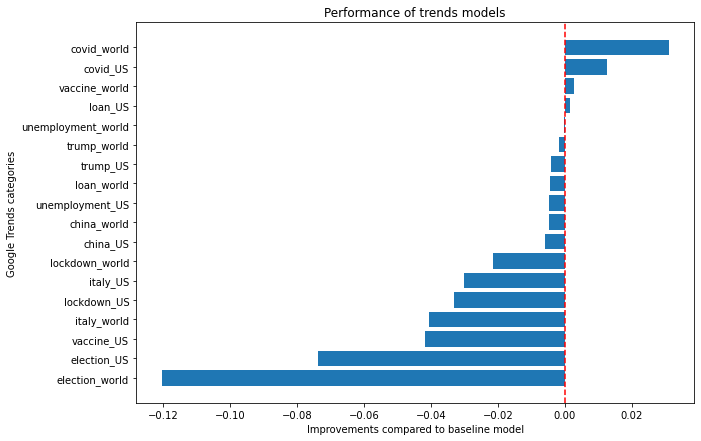

In [16]:
# Plot the improvements compared to baseline model.
plt.figure(figsize=(10, 7))
plt.barh(y=improvements.index, width=improvements.values)
plt.axvline(0, color='red', ls='--')
plt.xlabel('Improvements compared to baseline model')
plt.ylabel('Google Trends categories')
plt.title('Performance of trends models')

In [17]:
# improvements.to_csv(PLOT_DIR + 'improvements_2020.csv')

There you go. COVID-19, the most important event in the whole world, does have the most significant impact on the future trend of NASDAQ index.

## Turning points

Stock market is vulnerable to special event so it's not enough to draw a conclusion just with analysis in the whole year. 

Turning points are also valuable study subjects. Researchers in economics always hope to find vital elements in such turning periods to prepare the dramatic changes in the future. Here, we choose 4 turining points to dive in.

In [18]:
turning_points = [[pd.Timestamp('2020-02-10'), pd.Timestamp('2020-02-25')],
                  [pd.Timestamp('2020-03-10'), pd.Timestamp('2020-03-30')],
                  [pd.Timestamp('2020-08-20'), pd.Timestamp('2020-09-15')],
                  [pd.Timestamp('2020-10-10'), pd.Timestamp('2020-11-10')]]

Text(0.5, 1.0, 'Turning points of NASDAQ index (2020)')

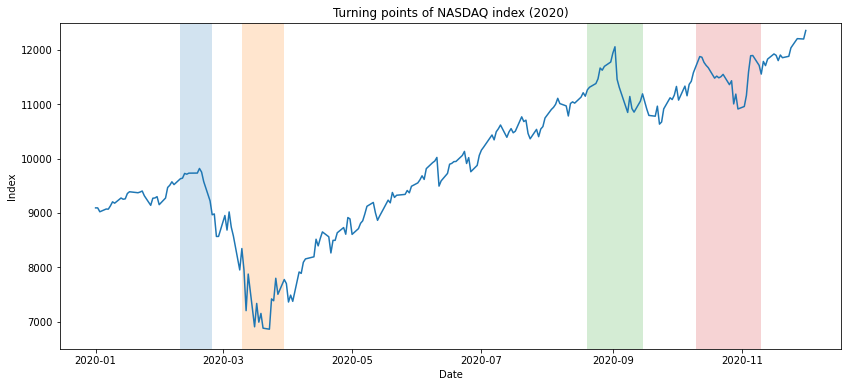

In [19]:
plt.figure(figsize=(14, 6))
y_min, y_max = 6500, 12500
plt.ylim([y_min, y_max])

plt.plot(df_ns['Close'])
for point_i in turning_points:
    plt.fill_betweenx([y_min, y_max], point_i[0], point_i[1], alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Turning points of NASDAQ index (2020)')
# plt.savefig(VIDEO_DIR + 'turning_periods.png', bbox_inches = 'tight', transparent = True)

Next, we calculate MAEs and improvements of trends models in each turning period.

In [20]:
df_turnings = pd.DataFrame(df_gt.columns.to_list(), columns=['Features'])

# Calculate MAEs of baseline model in each turning period.
base_turning_maes = []
for i in range(len(turning_points)):
    data_period = data_2020[turning_points[i][0]:turning_points[i][1]]
    mae = sum(abs(data_period['base'] - data_period[label]))/len(data_period)
    base_turning_maes.append(mae)
print(base_turning_maes)

[73.10888791968785, 307.131465611646, 113.648254688972, 103.55070906773523]


In [21]:
# Calculate MAEs and improvements of trends models in each turning period.
for i in range(len(turning_points)):
    data_period = data_2020[turning_points[i][0]:turning_points[i][1]]
    mae_col = f'Period_{i+1}'
    improvement_col = f'{mae_col}_ratio'
    maes = []
    for trend in df_turnings['Features']:
        mae = sum(abs(data_period[f'{trend}_pred'] - data_period[label]))/len(data_period)
        maes.append(mae)
    df_turnings[mae_col] = maes
    df_turnings[improvement_col] = -(df_turnings[mae_col] - base_turning_maes[i])/base_turning_maes[i]

In [22]:
df_turnings.head()

,Features,Period_1,Period_1_ratio,Period_2,Period_2_ratio,Period_3,Period_3_ratio,Period_4,Period_4_ratio
0,vaccine_world,72.801791,0.004201,307.749603,-0.002013,113.301656,0.003050,106.069103,-0.024320
1,vaccine_US,72.127055,0.013430,293.091340,0.045714,113.731134,-0.000729,103.375827,0.001689
2,unemployment_world,70.843047,0.030993,335.868552,-0.093566,110.175424,0.030558,103.708718,-0.001526
3,unemployment_US,70.721880,0.032650,337.974421,-0.100423,110.926453,0.023949,103.881593,-0.003195
4,trump_world,73.688757,-0.007932,314.647118,-0.024470,113.280068,0.003240,114.660231,-0.107286


Text(0.5, 1.0, 'Period 1')

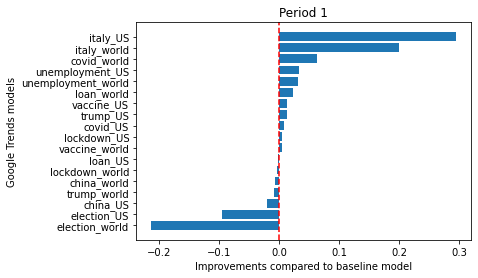

In [23]:
ratio = df_turnings[['Features', 'Period_1_ratio']].sort_values(by='Period_1_ratio')
plt.barh(y=ratio['Features'], width=ratio['Period_1_ratio'])
plt.axvline(0, color='red', ls='--')
plt.xlabel('Improvements compared to baseline model')
plt.ylabel('Google Trends models')
plt.title('Period 1')

Text(0.5, 1.0, 'Period 2')

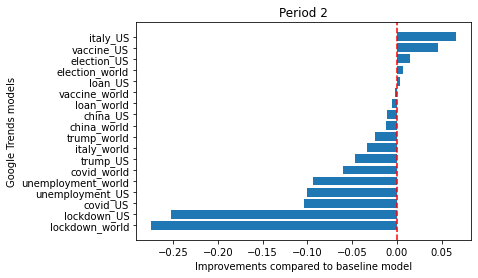

In [24]:
ratio = df_turnings[['Features', 'Period_2_ratio']].sort_values(by='Period_2_ratio')
plt.barh(y=ratio['Features'], width=ratio['Period_2_ratio'])
plt.axvline(0, color='red', ls='--')
plt.xlabel('Improvements compared to baseline model')
plt.ylabel('Google Trends models')
plt.title('Period 2')

Text(0.5, 1.0, 'Period 3')

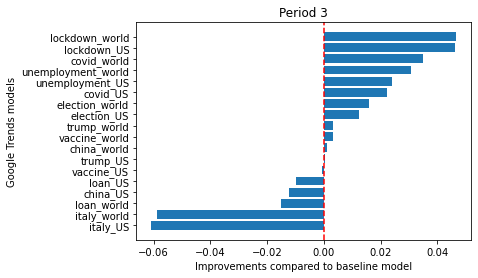

In [25]:
ratio = df_turnings[['Features', 'Period_3_ratio']].sort_values(by='Period_3_ratio')
plt.barh(y=ratio['Features'], width=ratio['Period_3_ratio'])
plt.axvline(0, color='red', ls='--')
plt.xlabel('Improvements compared to baseline model')
plt.ylabel('Google Trends models')
plt.title('Period 3')

Text(0.5, 1.0, 'Period 4')

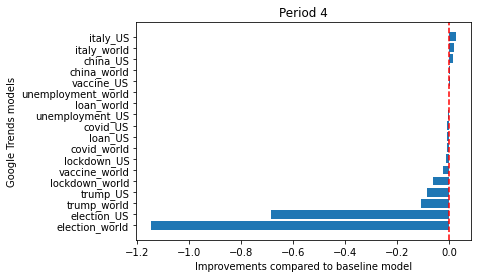

In [26]:
ratio = df_turnings[['Features', 'Period_4_ratio']].sort_values(by='Period_4_ratio')
plt.barh(y=ratio['Features'], width=ratio['Period_4_ratio'])
plt.axvline(0, color='red', ls='--')
plt.xlabel('Improvements compared to baseline model')
plt.ylabel('Google Trends models')
plt.title('Period 4')

Surprisingly, COVID does not have remarkable influence in all periods. To be more specific, the performance of NASDAQ index in turning points is more likely to be driven by special events such as election and lockdown, and these events usually tend to go against the predictions.

At last, we plot improvement trends for each trends models among these 4 periods.

In [27]:
# df_turnings.to_csv(PLOT_DIR + 'turning_points_ratio.csv')

In [28]:
import seaborn as sns

improvement_cols = ['Period_1_ratio', 'Period_2_ratio', 'Period_3_ratio', 'Period_4_ratio']
df_melt = pd.melt(df_turnings, id_vars=['Features'], value_vars=improvement_cols, var_name='Period', value_name='ratio')
df_melt

,Features,Period,ratio
0,vaccine_world,Period_1_ratio,0.004201
1,vaccine_US,Period_1_ratio,0.013430
2,unemployment_world,Period_1_ratio,0.030993
3,unemployment_US,Period_1_ratio,0.032650
4,trump_world,Period_1_ratio,-0.007932
...,...,...,...
67,election_US,Period_4_ratio,-0.684639
68,covid_world,Period_4_ratio,-0.009419
69,covid_US,Period_4_ratio,-0.008100
70,china_world,Period_4_ratio,0.004178


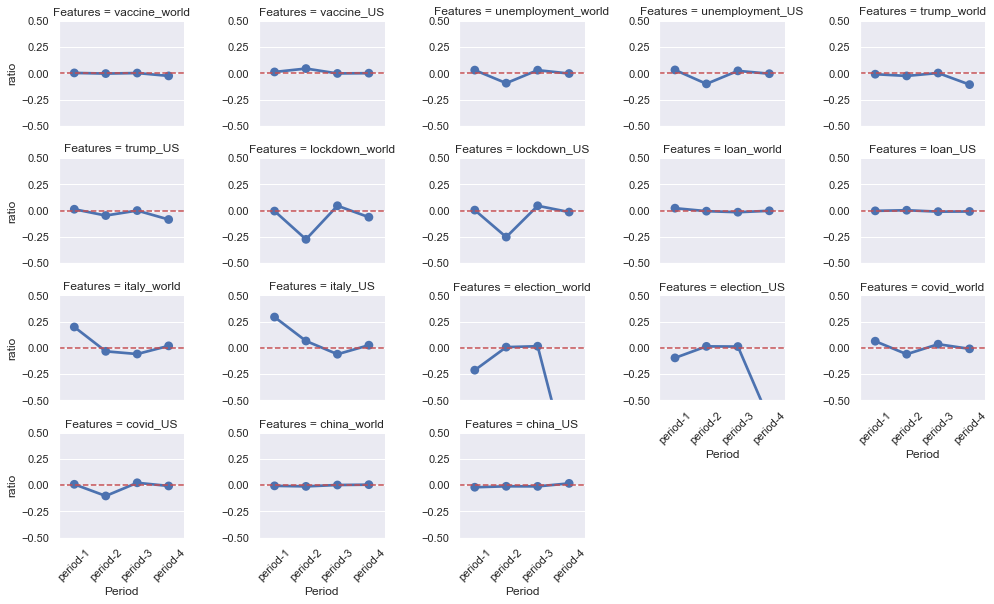

In [29]:
sns.set_theme(style='darkgrid')
g = sns.catplot(x='Period', y='ratio', col='Features', col_wrap=5, data=df_melt, 
                kind="point", orient="v", height=2,  aspect=1.4, sharey=False)
# g.set(ylim=(df_melt['ratio'].min(), df_melt['ratio'].max()))
g.set(ylim=(-0.5, 0.5))
g.set_xticklabels(['period-1', 'period-2', 'period-3', 'period-4'], rotation=45)
axes = g.fig.axes
for ax in axes:
    ax.axhline(0, color='r', ls='--')
# plt.savefig(PLOT_DIR + 'separated_features.png', bbox_inches='tight', transparent=False)